# Facebook: Paid vs Unpaid Posts

### Introduction:
Background: Facebook is one of the biggest social media platforms known to society, and it is a great place for businesses to reach consumers globally. It is a great way to collect data on different metrics and, specifically, we curious to see if we could predict whether a post is paid or unpaid. Hence, we chose two different metrics for Facebook posts that we thought would correlate the heaviest, lifetime post total reach and lifetime people who have liked the page and engaged with the post, to make a prediction on whether the post was paid or unpaid.

Question: How well do the two variables, lifetime post total reach and lifetime people who have liked the page and engaged with the post, predict if a post was paid or unpaid? In other words, which of the three has the highest accuracy of predicting a paid/unpaid post: 1. the first variable, 2. the second variable or 3. together?

Dataset: The dataset we have is from 2014 Facebook posts of a renowned cosmetic brand, and it shows the type of post (paid vs unpaid) as well as information on it, from the number of likes and shares to total impressions. This will be done through splitting the data into a training and testing set, and building a classifier thereafter.

### Methods and Results:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Paid,Lifetime_Post,Lifetime_Like_Engage
<fct>,<int>,<int>
0,2752,119
0,10460,1108
0,2413,132
⋮,⋮,⋮
0,3778,363
0,4156,370
NA,4188,316


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6080000,5,0.01496663,Model01
2,roc_auc,binary,0.5230159,5,0.04059705,Model01
4,accuracy,binary,0.6186667,5,0.02004440,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,binary,0.5602293,5,0.01222828,Model09
14,accuracy,binary,0.6906667,5,0.01292715,Model10
14,roc_auc,binary,0.5652557,5,0.02241967,Model10


.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.6906667,5,0.01292715
roc_auc,binary,0.5652557,5,0.02241967


Lifetime_Post,Lifetime_Like_Engage,Paid
<dbl>,<dbl>,<fct>
-0.4787425,-0.8038625,0
-0.1672168,0.8651353,0
-0.4924435,-0.7819242,0
⋮,⋮,⋮
-0.4372758,-0.3920976,0
-0.4219986,-0.3802847,0
-0.4207053,-0.4714130,NA


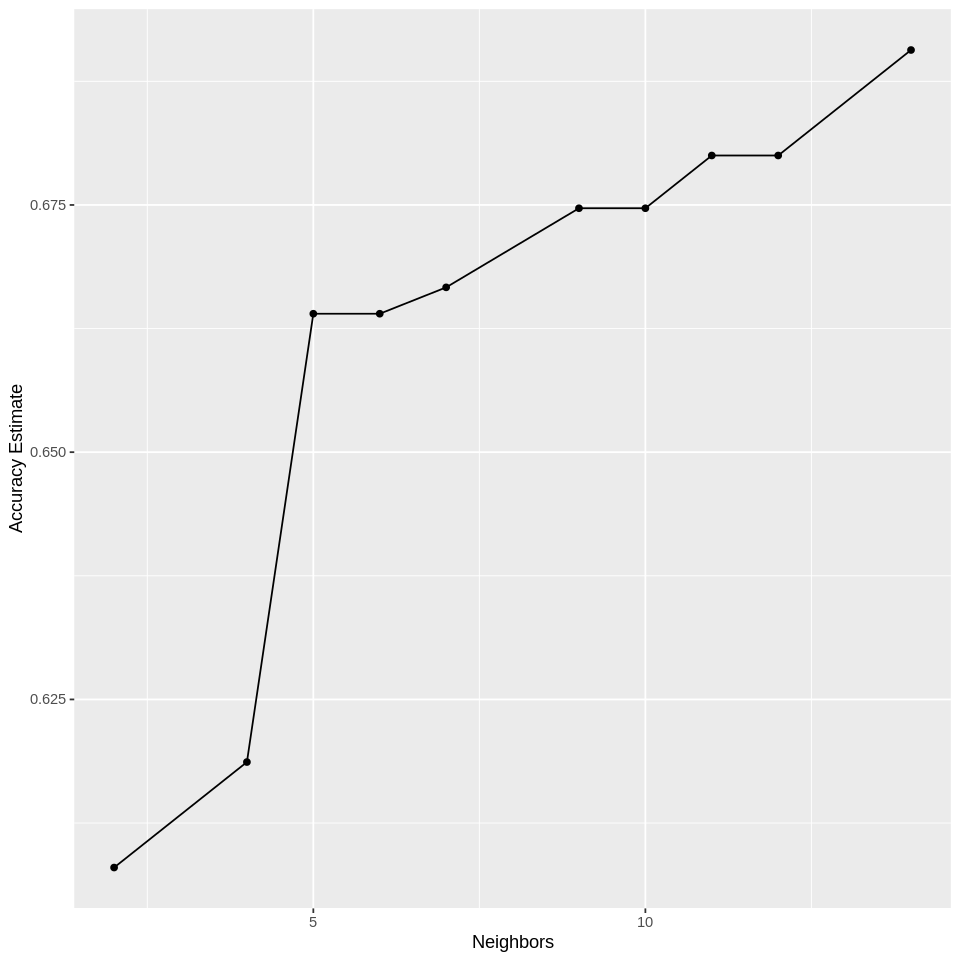

.pred_class
<fct>
1


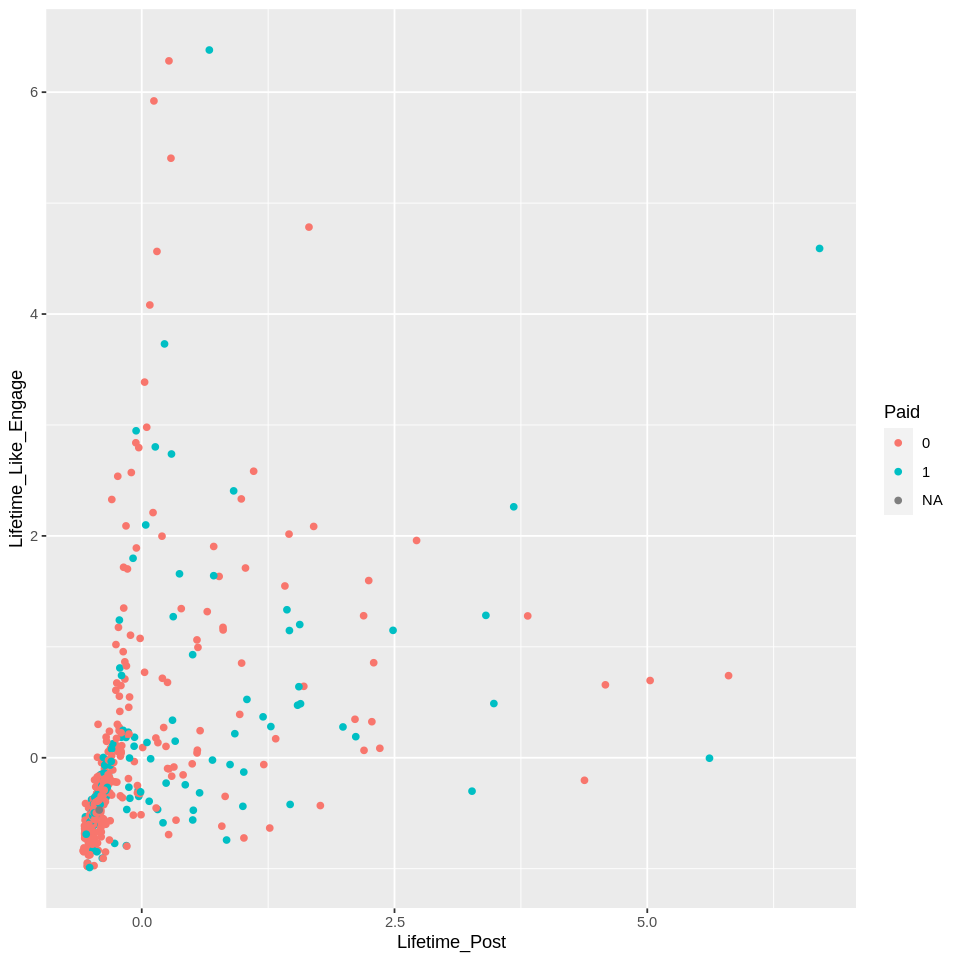

In [2]:
set.seed(3060)
options(repr.plot.width = 8, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)
facebook <- select(mutate(read.delim('data/dataset_Facebook.csv', sep=';'), Paid=as_factor(Paid)), Paid, Lifetime_Post = Lifetime.Post.Total.Reach, Lifetime_Like_Engage = Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post)
facebook

facebook_split <- initial_split(facebook, prop = 0.75, strata = Paid) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

facebook_recipe <- recipe(Paid ~ Lifetime_Post + Lifetime_Like_Engage, data = facebook_train) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = Paid)

knn_tune<- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
      set_engine('kknn') %>%
      set_mode('classification')

knn_results <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = facebook_vfold, grid = 10) %>%
      collect_metrics()

knn_results

accuracies <- knn_results %>% 
      filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 14) %>%
      set_engine('kknn') %>%
      set_mode('classification')

facebook_fit <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = facebook_vfold)

facebook_metrics<-collect_metrics(facebook_fit)
facebook_metrics

facebook_scaled <- facebook_recipe %>%
    prep() %>%
    bake(facebook)
facebook_scaled

facebook_plot <- ggplot(facebook_scaled, aes(x = Lifetime_Post, y = Lifetime_Like_Engage, colour = Paid)) +
    geom_point()
facebook_plot

facebook_fit_new <- workflow() %>%
    add_recipe(facebook_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = facebook_scaled)

new_obs <- tibble(Lifetime_Post = 1, Lifetime_Like_Engage = 0.5)

facebook_predict <- predict(facebook_fit_new, new_obs)
facebook_predict

### Discussion:

### Reference: